In [58]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Lab 1: Text Corpora and Language Modelling

This lab is meant to help you get familiar with some language data, and use this data to estimate N-gram language models

First you will use the **Penn Treebank**, which is a collection of newspaper articles from the newspaper 
The Wall Street Journal. The idea is to examine the data and notice interesting properties. This will not take more than a few lines of code.

Then you will use a corpus consisting of **TedX** talks. This you will use to estimate an **N-gram language model** for different orders of N, and use this this for some tasks.

The datasets are on blackboard under course materials. Download the zip and make sure to put the files in the same directory as the notebook.

### Rules
* The lab exercises should be made in **groups of two people**.

* The deadline is **Tuesday 7 nov 16:59**.

* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be `lab1_lastname1_lastname2.ipynb`, so for example `lab1_Jurafsky_Martin.ipynb`.

* The notebook is graded on a scale of **0-10**. The number of points for each question is indicated in parantheses. 

* The questions marked **optional** are not graded; they are an additional challenge for those interested in going the extra mile. 

Notes on implementation:

* You should **write your code and answers in this iPython Notebook** (see http://ipython.org/notebook.html for reference material). If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `# YOUR CODE HERE` comment.
    
    * For theoretical question, put your solution in the YOUR ANSWER HERE cell.
    
* Test your code and **make sure we can run your notebook**

# 1. Penn treebank

## Exercise 1.1 (40 points, 5 points per subquestion )

You are provided with a corpus containing words with their Part-of-Speech tags (POS-tags for short). The format is
**word|POS** (one sentence per line) and the file name is **sec02-22.gold.tagged**. This data is extracted from Sections 02-22 from the Penn Treebank: these sections are most commonly used for training statistical models like POS-taggers and parsers.

**[Hint]** **Figure 10.1** in chapter 10 of Jurafsky and Martin (see [here](https://web.stanford.edu/~jurafsky/slp3/10.pdf)) holds a summary of the 45 POS-tags used in the Penn Treebank tagset together with their meaning and some examples. (If you are keen on learning more about the word-classes represented POS-tags and their definitions you can do a litle reading ahead for next week and already have a look at section 10.1 of the same chapter).

**[Hint]** the Python library [collections](https://docs.python.org/2/library/collections.html) has an object called `Counter` which will come in handy for this exercise.

**(a)** How large is the corpus? (i.e. how **many tokens**). And what is the size of the **vocabulary** used in this corpus? 

Estimate the vocabulary size both by **lowercasing** all the words as well as by leaving the words in their **original orthography**. What is an advantage of lowercasing all the words in your corpus? What is a notable downside? **Give examples.**

In [59]:
import codecs


def read_corpus(path):
    tagged_tokens = []
    
    with codecs.open(path, "rb", "utf-8") as corpus_file:
        for line in corpus_file.readlines():
            raw_line = line.strip()
            raw_tokens = raw_line.split(" ")
            tokens = [tuple(token.split("|")) for token in raw_tokens]
            tagged_tokens.extend(tokens)
            
    return tagged_tokens

def get_vocabulary_size(tagged_tokens, selector=lambda token: token[0]):
    types = set()
    
    for tagged_token in tagged_tokens:
        types.add(selector(tagged_token))
        
    return len(types)
            
    
CORPUS_PATH = "./data/sec02-21.gold.tagged"
tagged_tokens = read_corpus(CORPUS_PATH)
corpus_size = len(tagged_tokens)
vocab_size = get_vocabulary_size(tagged_tokens)
vocab_size_lower = get_vocabulary_size(tagged_tokens, selector=lambda token: token[0].lower())

print("# of tokens: {}".format(corpus_size))
print("# of types: {}\n# of lowercase types: {}".format(vocab_size, vocab_size_lower))

# of tokens: 929552
# of types: 44210
# of lowercase types: 39384


The total number of tokens in the corpus is 929552. The number of types is 44210 and the number of types in case all the words are lowercased is 39384, so about 6000 less.

Lowercasing our corpus helps us to treat words the same way even if they are at the beginning of a sentence (which would usually capitalize them). Otherwise, "We" at the start of sentences would be seen as a different type as "we" somewhere in the middle of a sentence which we would like to avoid, as they are intuitively the same word. 

Notable downsides can be seen in the corpus when looking at examples were the lowercased version differs from the original: For example, the company name American Express is lowercased and therefore indistinguishable from the "normal" words "american" and "express". We therefore loose information which could e.g. be valuable for Named Entity Recognition, where Capialization of proper nouns is a valuable features. It could also create ambiguities in cases where e.g. a proper noun is also a verb when lowercase.



------
For the rest of this exercise you should use the **original orthography** of the data when answering the questions.

------


**(b)** Plot a graph of word frequency versus rank of a word, in this corpus. Does this corpus obey **Zipf’s law**?

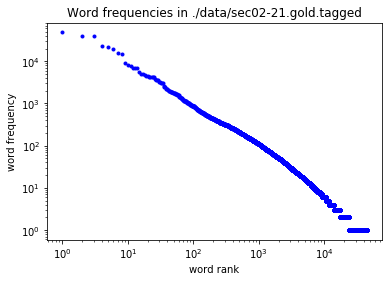

In [60]:
from collections import defaultdict
import matplotlib.pyplot as plt

def count_frequencies(tagged_tokens, selector=lambda tagged_token: tagged_token[0]):
    frequencies = defaultdict(int)
    
    for tagged_token in tagged_tokens:
        frequencies[selector(tagged_token)] += 1
        
    sorted_frequencies = sorted(list(frequencies.items()), key=lambda el: el[1], reverse=True)
        
    return sorted_frequencies

token_freqs = count_frequencies(tagged_tokens)

plt.scatter(range(1, len(token_freqs) + 1), [freq for _, freq in token_freqs], marker=".", color="blue")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("word frequency")
plt.xlabel("word rank")
plt.title("Word frequencies in {}".format(CORPUS_PATH))
plt.show()

**(c)** What are the **20 most common words** in the corpus and how often do they occur? What is the 50th most common word, the 100th and the 1000th and how often do they occur?

In [61]:
print("The 20 most common words are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({})".format(rank, token_freq[0], token_freq[1]) 
        for rank, token_freq in zip(range(1, 21), token_freqs[:20])]
    ))
)

other_ranks = [50, 100, 1000]
print("Other notable words and their frequencies are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({})".format(rank, *token_freqs[rank-1]) 
        for rank in other_ranks]
    )
))

The 20 most common words are:
1. , (48310)
2. the (40839)
3. . (38798)
4. of (22782)
5. to (22056)
6. a (19171)
7. and (15906)
8. in (15085)
9. 's (9249)
10. that (7951)
11. for (7912)
12. $ (7125)
13. is (6893)
14. The (6791)
15. said (5597)
16. on (5112)
17. % (4871)
18. it (4639)
19. by (4450)
20. from (4437)

Other notable words and their frequencies are:
50. had (1755)
100. A (860)
1000. man (109)



**(d)** How many different Part-of-speech tags are present in the corpus?

In [62]:
pos_vocab_size = get_vocabulary_size(tagged_tokens, selector=lambda token: token[1])

print("There are {} different Part-of-Speech tags in the corpus.".format(pos_vocab_size))

There are 48 different Part-of-Speech tags in the corpus.


**(e)** Print a list of the **10 most commonly occurring POS tags** in the data. For each of these POS tags, what are the **3 most common words** that belong to that class?

In [63]:
pos_freqs = count_frequencies(tagged_tokens, selector=lambda tagged_token: tagged_token[1])

token_pos_tags = defaultdict(set)  # Possible pos tags for every token
for token, pos in tagged_tokens:
    token_pos_tags[token].add(pos)

token_frequencies_by_pos = defaultdict(lambda: defaultdict(int))  # Most frequent words per PoS tag
for token, tag in tagged_tokens:
    token_frequencies_by_pos[tag][token] += 1
    
sorted_token_frequencies_by_pos = {
    pos: sorted(list(frequencies.items()), key=lambda el: el[1], reverse=True)
    for pos, frequencies in token_frequencies_by_pos.items()
}

print("The 10 most common PoS tags with their three most common words are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({}): {}".format(
            rank, *pos_freqs[rank-1], 
            ", ".join(["{} ({})".format(token, freq) for token, freq in sorted_token_frequencies_by_pos[pos_freqs[rank-1][0]][:3]])) 
        for rank, token_freq in zip(range(1, 11), pos_freqs[:10])]
    ))
)


The 10 most common PoS tags with their three most common words are:
1. NN (132134): % (4866), company (2457), year (2220)
2. IN (99413): of (22778), in (14852), for (7907)
3. NNP (90711): Mr. (4147), U.S. (1577), Corp. (1186)
4. DT (82147): the (40831), a (19151), The (6753)
5. JJ (59643): new (1396), other (1298), last (990)
6. NNS (59332): years (1164), shares (1128), sales (939)
7. , (48314): , (48310), an (1), 2 (1)
8. . (39252): . (38798), ? (392), ! (62)
9. CD (36148): million (4355), billion (1780), one (1203)
10. RB (30232): n't (3211), also (1420), not (1287)



**(f)** A single word may have several POS-tags. For example, *record* can be a both a **noun** *(buy a record)* or a **verb** *(record a lecture)*. This make POS-tags extremely useful for **disambiguation**.

What percentage of the words in the vocabulary is **ambiguous**? (i.e. have more than one POS tag?) What are the 10 most frequent combinations of POS tags in the case of ambitguity? Which words are **most ambiguous**? Give some of them.

In [64]:
pos_frequencies_by_type = defaultdict(lambda: defaultdict(int))  # Most frequent words per PoS tag
for token, tag in tagged_tokens:
    pos_frequencies_by_type[token][tag] += 1
    
sorted_pos_frequencies_by_type = {
    pos: sorted(list(frequencies.items()), key=lambda el: el[1], reverse=True)
    for pos, frequencies in pos_frequencies_by_type.items()
}

ambiguous_pos_combination_frequencies = defaultdict(int)
for pos, frequencies in pos_frequencies_by_type.items():
    if len(frequencies) > 1:
        ambiguous_pos_combination_frequencies[tuple(sorted(frequencies.keys()))] += 1
sorted_ambiguous_pos_combination_frequencies = sorted(
    list(ambiguous_pos_combination_frequencies.items()), key=lambda el: el[1], reverse=True
)
print("The 10 most PoS combinations for ambiguous words are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({})".format(rank, *combination_frequencies) 
        for rank, combination_frequencies in zip(range(1, 11), sorted_ambiguous_pos_combination_frequencies[:10])]
    ))
)

percentage_ambiguous_types = len([
    type_ for type_, pos_frequencies in sorted_pos_frequencies_by_type.items() 
    if len(pos_frequencies) > 1 
]) / len(sorted_pos_frequencies_by_type.items()) * 100.0
print("{:.2f} % of types are ambiguous.\n".format(percentage_ambiguous_types))

sorted_types_by_ambiguity = sorted(list(sorted_pos_frequencies_by_type.items()), key=lambda el: len(el[1]), reverse=True)
print("The 5 most ambiguous words in the corpus are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({}: {})".format(rank, token_pos_frequencies[0], len(token_pos_frequencies[1]), ", ".join([pos for pos, _ in token_pos_frequencies[1]])) 
        for rank, token_pos_frequencies in zip(range(1, 6), sorted_types_by_ambiguity[:15])]
    ))
)

The 10 most PoS combinations for ambiguous words are:
1. ('VBD', 'VBN') (772)
2. ('JJ', 'NN') (662)
3. ('NN', 'NNP') (549)
4. ('VB', 'VBP') (375)
5. ('NNS', 'VBZ') (355)
6. ('NN', 'VB') (351)
7. ('NN', 'VBG') (315)
8. ('JJ', 'VBD', 'VBN') (237)
9. ('NN', 'VB', 'VBP') (233)
10. ('JJ', 'NNP') (218)

13.47 % of types are ambiguous.

The 5 most ambiguous words in the corpus are:
1. set (7: VBN, VBD, VB, NN, VBP, JJ, VBZ)
2. many (7: JJ, NN, DT, RB, PDT, VB, NP)
3. open (7: JJ, VB, VBP, RB, RP, NN, VBZ)
4. down (7: RB, RP, IN, JJ, RBR, VBP, NN)
5. in (6: IN, RP, RB, CC, FW, RBR)



**(g)**  Print some of these words with their multiple POS-tags. Do you **understand the ambiguity**? Use figure 10.1 mentioned above to interpret the POS-tags.

In [65]:
sorted_types_by_ambiguity = sorted(list(sorted_pos_frequencies_by_type.items()), key=lambda el: len(el[1]), reverse=True)
print("The 5 most ambiguous words in the corpus are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({}: {})".format(rank, token_pos_frequencies[0], len(token_pos_frequencies[1]), ", ".join([pos for pos, _ in token_pos_frequencies[1]])) 
        for rank, token_pos_frequencies in zip(range(1, 6), sorted_types_by_ambiguity[:15])]
    ))
)

The 5 most ambiguous words in the corpus are:
1. set (7: VBN, VBD, VB, NN, VBP, JJ, VBZ)
2. many (7: JJ, NN, DT, RB, PDT, VB, NP)
3. open (7: JJ, VB, VBP, RB, RP, NN, VBZ)
4. down (7: RB, RP, IN, JJ, RBR, VBP, NN)
5. in (6: IN, RP, RB, CC, FW, RBR)



**(h)** Ambiguous words do not account for a great percentage of the vocabulary. Yet they are among the most commonly occuring words of the English language. What **percentage of the dataset is ambiguous**?

In [66]:
percentage_ambiguous_tokens = sum([
    freq for token, freq in token_freqs 
    if len(sorted_pos_frequencies_by_type[token]) > 1 
]) / corpus_size * 100

print("{:.2f} % of the data set is ambiguous.".format(percentage_ambiguous_tokens))

55.08 % of the data set is ambiguous.


## Exercise 1.2 (10 points, 5 per subquestion)

You are also provided with another file called **sec00.gold.tagged**. 
Section 00 of the Penn Treebank is typically used as development data.

**(a)** How many **unseen words** are present in the development data (i.e., words that have not occurred in the training data)?

In [71]:
SEC_00_CORPUS_PATH = "./data/sec00.gold.tagged"
sec0_tagged_tokens = read_corpus(SEC_00_CORPUS_PATH)

tokens_training = {token for token, _ in tagged_tokens}
unseen_tokens = sum(
    [1 for token, _ in sec0_tagged_tokens if token not in tokens_training]
)
print(
    "{} tokens in the development data are unseen ({:.2f} %).".format(
        unseen_tokens, unseen_tokens / len(sec0_tagged_tokens) * 100
    )
)

1728 tokens in the development data are unseen (3.80 %).


**(b)** What are the three **POS tag categories** that the most **unseen words** belong to?

In [81]:
unseen_pos_categories = defaultdict(int)

for token, pos in sec0_tagged_tokens:
    if token not in tokens_training:
        unseen_pos_categories[pos] += 1
        
sorted_unseen_pos_categories = sorted(list(.items()), key=lambda el: len(el[1]), reverse=True)
        
print("The three top PoS tags that the most unseen words belong to are:\n{}\n".format(
    "\n".join(
        ["{}. {} ({})".format(rank, *combination_frequencies) 
        for rank, combination_frequencies in zip(range(1, 4), sorted_ambiguous_pos_combination_frequencies[:10])]
    ))
)

# 2. Language Models

This part of the lab will be covered in the Wednesday lecture. If you have prior exposure to NLP, go ahead and finish this part! If you don't, start anyway, and this part will be clear after the lecture. 

Reference **chapter 4** of J&M *Language Modeling with N-Grams*. 

----------

Models that assign **probabilities** to **sequences of words** are called language **language
modelels** or **LMs**. The simplest model that assigns probabilities to sentences and sequences of words is the **N-gram** model.

Recall that an *N*-gram language model uses **conditional probabilities** of the form
    
$$P(w_k \mid w_{k-N+1} \dots w_{k-1})$$

to **approximate** the full **joint probability**

$$P(w_1 \dots w_n)$$

of a sequence of words $w_1 \dots w_n$.

The easiest way of obtaining estimates for the probabilities $P(w_k \mid w_{k-N+1} \dots w_{k-1})$ is to use the **maximum likelihood estimate** or **MLE**, a widely used statistical estimation method ([read more]((https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)). You count and normalize:

$$P_{MLE}(w_k \mid w_{k-N+1} \dots w_{k-1}) = \frac{C(w_{k-N+1} \dots w_{k-1} w_k)}{C(w_{k-N+1} \dots w_{k-1})}.$$


## Exercise 2.1 (25 points)

**(a) ** Complete the function `train_ngram` so that you can train a count-based $N$-gram language model on the data found in `data/ted-train.txt` and train this for $N=2,3,4$. **15 points**

**(b) ** Extend the function above so that it accepts a parameter `k` for optional add-$k$ smoothing. **10 points**

**[Datastructure hint]** If you store the smoothed language in a naive manner (that is, to store *all* the numbers separately) your datastructure will get huge! If $V$ is the vocabulary then the smoothed bigram model assigns probabilities to $|V|^2$ entries. If $|V|$ is around 80k, the naive way requires you to store more than 64 billion floats. Yet almost all of these are actually just $P(w_n|w_{n-1}) = \frac{k}{N + k|V|}$, with $k$ the value with which you smooth and $N=C(w_{n-1})$. Think about how you use this fact to make your model work in practice.

**[Python hint]** The `collections` library has another useful datastructure: the `defaultdict`. Some example uses:

In [68]:
from collections import defaultdict

d = defaultdict(float)
d["new key"]

0.0

Compare that to an ordinary dictionary:

In [69]:
d = dict()
d["new key"]

KeyError: 'new key'

Other datatypes as `default_factory`:

In [71]:
d = defaultdict(int)
d["new key"]

0

In [72]:
d = defaultdict(list)
d["new key"]

[]

Converting an already existing `dict`:

In [37]:
d1 = {k: "value" for k in range(1, 11)}
d = defaultdict(float, d1) # convert it to a defaultdict
print(d[5])
print(d[100])

value
0.0


This doesn't work:

In [77]:
d = defaultdict(10)

TypeError: first argument must be callable or None

Use a `lambda` to make the number `10` `callable`":

In [38]:
d = defaultdict(lambda: 10)
d["new key"]

10.0

In [39]:
d = defaultdict(lambda: defaultdict(float))
d["new key"]

defaultdict(float, {})

Clever use of a `defaultdict` can be the solution to the problem of data-storing in a smoothing $N$-gram pointed out above:
    
    ngram = defaultdict(lambda: k/(N+kV), ngram)

The following function is given:

In [82]:
train_file = "ted-train.txt"

def read(fname, max_lines=np.inf):
    """
    Reads in the data in fname and returns it as
    one long list of words. Also returns a vocabulary in
    the form of a word2index and index2word dictionary.
    """
    data = []
    # w2i will automatically keep a counter to asign to new words
    w2i = defaultdict(lambda: len(w2i))
    i2w = dict()
    start = "<s>"
    end = "</s>"
    
    with open(fname, "r") as fh:
        for k, line in enumerate(fh):
            if k > max_lines:
                break
            words = line.strip().split()
            # assign an index to each word
            for w in words:
                i2w[w2i[w]] = w # trick
            
            sent = [start] + words + [end]
            data.append(sent)

    return data, w2i, i2w

In [ ]:
def train_ngram(data, N, k=0):
    """
    Trains an n-gram language model with optional add-k smoothing
    and additionaly returns the unigram model
    
    :param data: text-data as returned by read
    :param N: (N>1) the order of the ngram e.g. N=2 gives a bigram
    :param k: optional add-k smoothing
    :returns: ngram and unigram
    """
    ngram = defaultdict(Counter) # ngram[history][word] = #(history,word)
    unigram = defaultdict(float, Counter(data)) # default prob is 0.0           

    ## YOUR CODE HERE ##
    
    return ngram, unigram

data, w2i, i2w = read(train_file)
# bigram, unigram = train_ngram(data, N=2, k=0)
# bigram_smoothed, unigram_smoothed = train_ngram(data, N=2, k=1)

In [85]:
data[2]

['<s>',
 'Both',
 'are',
 'necessary',
 ',',
 'but',
 'it',
 'can',
 'be',
 'too',
 'much',
 'of',
 'a',
 'good',
 'thing',
 '.',
 '</s>']

## Exercise 2.2 (5 points)

You can use an *N*-gram language model to **generate text**. The higher the order *N* the better your model will be able to catch the long-range dependecies that occur in actual sentences and the better your changes are at generating sensible text. But beware: **sparsity** of language data will quickly cause your model to reproduce entire lines from your training data; in such cases only one $w_k$ was observed for the histories $w_{k-N+1}\dots w_{k-1}$ in the entire training-set.

**Complete** the function `generate_sent`. It takes a language model `lm` and an order `N` and should generate a sentence by **sampling** from the language model.

**[Hint]** You can use the method of [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to generate a sample from a **categorical distribution**, $p_1\dots p_k$ such that $p_i \geq 0$ and $\sum_{i=1}^k p_i = 1$, as follows:

In [263]:
from random import random

P = [0.2,0.5,0.2,0.1]

def sample(P):
    u = random() # uniformly random number between 0 and 1
    p = 0
    for i, p_i in enumerate(P):
        if p > u: 
            return i # the first i s.t. p1 + ... + pi > u
        p += p_i
        
print(sample(P))

print(Counter([sample(P) for i in range(1000)])) # check to see if the law of large numbers is still true

2
Counter({2: 512, 1: 200, 3: 196, None: 92})


Inverse transform sampling in the words of Jurafsky and Martin:

> Imagine all the words of the English language covering the probability space
between 0 and 1, each word covering an interval proportional to its frequency. We
choose a random value between 0 and 1 and print the word whose interval includes
this chosen value.

(J&M, section 4.3)

In [63]:
def generate_sent(lm, N):
    ## YOUR CODE HERE ##
    raise NotImplementedError

### [Optional]

For how many of the histories $w_{k-N+1}\dots w_{k-1}$ is the number of continuations $w_n$ equal to **one**? Calculate the percentage of such cases for the different orders *N*.

And which history has the **most possible continuations**?

In [ ]:
### ANSWER ###

## Excercise 2.3 (5 points)

Let $V$ denote our vocabulary. Recall that for any $w$ in $V$ `bigram[w]` defines a conditional probability $p(v|w)$ over $v$ in $V$. In the case of an **unsmoothed bigram**, $p(v|w) = 0$ for most $v\in V$, whereas in the **smoothed bigram** smoothing took care that $p(v|w) \geq 0$ for *all* $v$.

The function `plot_bigram_dist(word, bigram, smoothbigram, k=30)` plots shows $p(v|word)$ for the `k` words $v$. One bar shows the probabilities in `bigram` and one in `smoothbigram`. 

**(a)** Use this function to plot the distribution for at least two words `w` and answer the questions
* What is the effect of smoothing on the bigram distribution of frequent words? 
* What is the effect in the case of infrequent words?
* Explain the difference between the two based on the raw counts of `w` 

**(b)** Now experiment with $k$ much smaller than 1 (but greater than 0!) 
* What are the effects?


**[Hint]** Remember that add-1 smoothing turns 
$$P(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n})}{C(w_{n-1})}$$
into
$$P_{add-1}(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n}) + 1}{C(w_{n-1}) + |V|}.$$

What happens when $C(w_{n-1})$ is relatively big (similiar in of size as $ |V| $)? And what if $C(w_{n-1})$ is small? 

In [193]:
import pandas as pd
import seaborn as sns    

def plot_bigram_dist(word, bigram, smoothbigram, k=30):
    d = bigram[word]
    ds = smoothbigram[word]
    
    # sort the probabilities
    d_sort = sorted(d.items(), reverse=True, key=lambda t: t[1])[0:k]
    ds_sort = sorted(ds.items(), reverse=True, key=lambda t: t[1])[0:k]
    
    _, probs = zip(*d_sort)
    smooth_ws, smooth_probs = zip(*ds_sort)
    
    # make up for the fact that in the unsmoothed case  probs is generally less than k long
    probs = probs + (0,) * (k-len(probs)) 

    w_data = pd.DataFrame({"w": smooth_ws * 2,
                           "P({}|w)".format(word): probs + smooth_probs,
                           "smoothing": ["unsmoothed"]*k + ["smoothed"]*k})
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.xticks(rotation=90)
    g = sns.barplot(ax=ax, x="w", y="P({}|w)".format(word), hue="smoothing",
                    data=w_data, palette="Blues_d")    

In [86]:
## YOUR CODE HERE ##

YOUR ANSWERS HERE


**Recall** that if we have a sentence $w_1,\dots,w_n$ we can write

$$P(w_1\dots w_n) = P(w_1)P(w_2|w_1) \cdots P(w_i|w_1 \dots w_{n-1}) \approx P(w_1)P(w_2|w_1)\cdots P(w_{N-1}|w_1\dots w_{N-2})\prod_{i=N}^{n} P(w_i|w_{i-(N-1)}\dots w_{i-1})$$

where in the last step we make an $N$-gram approximation of the full conditionals.

For example, in the case of a bigram (N=2), the above expression reduces to

$$P(w_1 \dots w_n)\approx P(w_1)\prod_{i=2}^{n} P(w_i| w_{i-1}).$$

## Exercise 2.4 (5 points)

The following sentences are taken from the **training data**. Use your **unsmoothed unigram**, **bigram**, and **trigram** language model to estimate their **probabilities**:

    1. Every day was about creating something new .
    2. In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought 
       together in a collision , producing a burst of pure energy .

**Repeat** this with the **smoothed (add-1)** versions of the N-grams. What is the effect of smoothing on the probabilities?


In [ ]:
## YOUR CODE HERE ##

YOUR ANSWERS HERE

## Exercise 2.5 (5 points)

The above sentences were taken from the training set, hence they will all have probability greater than 0. The big challenge for our language model are of course with sentence that contain unseen N-grams: if such an N-gram occurs our model immediately assigns the sentence probability zero.

The following three senteces are taken from the **test set** availlable in the file **ted-test.txt**. What probabilities do your smoothed and unsmoothed language models asign in this case?

    1. Because these robots are really safe .
    2. We have sheer nothingness on one side , and we have this vision of a reality that encompasses every 
       conceivable world at the other extreme : the fullest possible reality , nothingness , the simplest possible 
       reality .

In [ ]:
### YOUR CODE HERE ###

YOUR ANSWERS HERE

### [Optional]

**Optional** What percentage of the sentences in the test set get assigned probability 0 under your smoothed and unsmoothed language models? 

In [272]:
### ANSWER HERE ###

## Exercise 2.6 (5 points)

**Perplexity** is very frequently used **metric** for evaluating probabilistic models such as language models. The perplexity (sometimes called **PP** for short) of a language model on a sentence is the **inverse probability** of the sentence, **normalized** by the number of words:

$$PP(w_1 \dots w_n) = P(w_1\dots w_n)^{-\frac{1}{n}}.$$

Here we can again approximate $P(w_1 \dots w_n)$ with N-gram probabilities, as above.
Note: $(x_1\cdots x_n)^{-\frac{1}{n}}$ is the **geometric mean** of the numbers $x_1,\dots,x_n$. It is like the (regular) artithmetic mean, but with **products** instead of **sums**. The geometric mean is a more natural choice in the case of *PP* because behind $P(w_1\dots w_n)$ is a series of $n$ products ([more here](https://en.wikipedia.org/wiki/Geometric_mean)).



Compute the perplexity of the training sentences from excercise 2.1. What big difference between the **probabilities** of the sentences and the **perplexities** of the sentences do you notice?

In [ ]:
### YOUR CODE HERE ###

YOUR ANSWER HERE

# That's it!

Congratulations, you have made it to the end of the tutorial. Here we will recap the gist of this notebook. 

**Make sure all your cells can be executed and all your answers are there. Then, read on if you're interested!**

-----

By now you should have a solid feeling for the problem of **sparsity in language data**; there's just never enough data. For the task of language modelling, we saw that sparsity is a serious challenge. 

It would be great to be able to model $p(w_n|w_1 \dots w_{n-1})$ for unlimited $n$: the larger $n$ the better our language model should become at capturing the long-range dependencies between words that characterize actual human sentences, and the more probability our model will asign to such sentences as opposed to sentences that are word-soup. But in the N-gram approach, increasing $n$ will quickly kill all generalizing abilities of the model: the model will start to asign probabilities only to sentences it has seen in the training data.

So, where to go from here? Here are three directions that we could head in.

### Smoothing

We have seen one example of smoothing in this lab: add-k smoothing. This is an easy method, both conceptually and implementation-wise. But the results are not great, and the effects it has on the distributions can be extreme.

A much more sophisticated method of smoothing is so-called **Kneser-Ney smoothing**. The method is described in detail in section 4.5 of J&M (3rd edition). This is one of the best performing N-gram smoothing methods, and up to a few years ago a popular implementation of it called [KenLM](https://kheafield.com/code/kenlm/) gave state of the art results.

### From words to characters

In this lab we have considered language modeling as the task of predicting a **word** $w_n$ based on a history of **words** $w_1\cdots w_n$. What if instead we let our basic units of modelling be **characters**? The task then becomes to model $p(c_k\mid c_{k-N-1}\dots c_{k-1})$ where each $c_i$ is now an ASCII character instead of an entire word.

Suddenly sparsity of data is no longer a problem! The set of characters to use is tiny (< 100) compared to even a small-sized vocabulary as today. Have a look at this very illustrative notebook written by Yoav Golberg to see such a method in action: [The unreasonable effectiveness of Character-level Language Models](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139).

(So what is the downside?)


### Neural language models

The above notebook was actually written as a response to this blog post by Andrej Karpathy: [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Go ahead and read it if you haven't already: it is a superb introduction to the topic of Recurrent Neural Networks.

Neural language models solve the problem of data sparsity in a different manner. Instead of estimating the probabilities $p(w_k\mid w_{k-N-1}\dots w_{k-1})$ by counting occurences in the data, they use a neural network $f_{\theta}$ parametrized by parameters $\theta$ to predict this probability. The parameters $\theta$ are learned through optimization. 

The simplest approach goes like this: each word in the history $w_{k-N-1}\dots w_{k-1}$ is embedded separately giving  vectors $e_{k-N-1}\dots e_{k-1}$ and then concatenated into one long vectors $[e_{k-N-1};\dots ;e_{k-1}]$. The network then uses this history vector to predict a probability distribution over words $w$ in the vocabulary $V$:

$$p(w \mid w_{k-N-1}\dots w_{k-1}) = f_{\theta}([e_{k-N-1};\dots;e_{k-1}]).$$

(In order to produce legitimate probabilities the final layer of such a network will be for example a $softmax$.)

This provides a solution to the sparsity problem by having the network let the individual embeddings of the words in the history interact through its non-linear transforamtion. We are letting the network figure out the smoothing itself!

RNNs are a clever extension of this idea, where a hidden state vector $h$ is re-used and updated at each step $k$ in order to store the information of the entire history up to step $k-1$. That is, an RNN actually does away with the N-order approximation; it tries to model the full conditional directly! That means that

$$p(w \mid w_1\dots w_{k-1}) \approx RNN_{\theta}([e_{k-1};h_{k-1}])$$

where the hidden state $h_{k-1}$ is a compression of the *entire history* $w_1\dots w_{k-1}$.

Another great place to learn about RNNs, their problems, and solutions to those, is on the blog of [Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). The project on language modelling will involve learning more about these methods. 

-----------
(And now, it's time to read the classic essay by Eugene Wigner that gave both of the posts their title: [The Unreasonable Effectiveness of Mathematics in the Natural Sciences](http://www.dartmouth.edu/~matc/MathDrama/reading/Wigner.html))